### Let's examine the effect of replacing Llama's dense attention with the hash attention kernel.

In [36]:
import torch
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             torch_dtype=torch.bfloat16,
                                             device_map="cuda:2")


In [2]:
conversation = [
    {"role": "user", "content": "Hello, how are you?"},
]
model_input = tokenizer.apply_chat_template(conversation, return_tensors="pt", add_generation_prompt = True).to(model.device)
response_tensor = model.generate(model_input, max_new_tokens = 20, temperature = 0.7)
tokenizer.decode(response_tensor[0][len(model_input[0]):])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


"Hello. I'm just a language model, so I don't have emotions or feelings like humans do"

In [3]:
from torch import nn
from transformers.models.llama.modeling_llama import LlamaAttention, LlamaConfig, Cache, FlashAttentionKwargs, apply_rotary_pos_emb, repeat_kv
from typing import Tuple, Optional, Unpack
from tqdm import tqdm
from copy import deepcopy
from source.scfa_paper.scfa_wrapper import hash_sparse_attention
from source.experiments.training.utils import scfa_hash_attn, get_vector_hash

class HashAttention(LlamaAttention):
    def __init__(self, config: LlamaConfig, layer_idx: int, num_buckets: int, device):
        super().__init__(config, layer_idx)
        self.vector_hash = get_vector_hash(D = self.head_dim, num_buckets = num_buckets, device = device)
        self.num_buckets = num_buckets

    def forward(
        self,
        hidden_states: torch.Tensor, # (batch_size, seq_len, hidden_size)
        position_embeddings: Tuple[torch.Tensor, torch.Tensor],
        attention_mask: Optional[torch.Tensor],
        past_key_value: Optional[Cache] = None,
        cache_position: Optional[torch.LongTensor] = None,
        **kwargs: Unpack[FlashAttentionKwargs],
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        input_shape = hidden_states.shape[:-1]
        hidden_shape = (*input_shape, -1, self.head_dim)

        query_states = self.q_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        key_states = self.k_proj(hidden_states).view(hidden_shape).transpose(1, 2)
        value_states = self.v_proj(hidden_states).view(hidden_shape).transpose(1, 2)

        cos, sin = position_embeddings
        query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

        """
        Shapes:
        query_states: (batch_size, num_heads, seq_len, head_dim)
        key_states: (batch_size, num_heads, seq_len, head_dim)
        value_states: (batch_size, num_heads, seq_len, head_dim)
        """

        try:
            if past_key_value is not None:
                # sin and cos are specific to RoPE models; cache_position needed for the static cache
                cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
                key_states, value_states = past_key_value.update(key_states, value_states, self.layer_idx, cache_kwargs)

            attn_output = scfa_hash_attn(
                q = query_states,
                k = repeat_kv(key_states, self.num_key_value_groups),
                v = repeat_kv(value_states, self.num_key_value_groups),
                num_buckets = self.num_buckets,
                sm_scale = self.scaling,
                vector_hash = self.vector_hash,
            )

            attn_output = attn_output.reshape(*input_shape, -1).contiguous()
            attn_output = self.o_proj(attn_output)
        
        except Exception as e:
            print(query_states.shape, self.num_buckets)
            print(e)
        
        return attn_output, None
    
# Monkeypatch time
def monkeypatch(model, num_buckets: int, one_at_a_time: bool = False):
    n_modules_to_replace = len(list(filter(lambda x: isinstance(x, LlamaAttention), model.modules())))
    pbar = tqdm(total = n_modules_to_replace, desc = "Replacing attention modules")
    if one_at_a_time:
        pbar.disable = True    
    for name, module in model.named_modules():
        if isinstance(module, LlamaAttention):
            # Construct new module
            new_attn_module = HashAttention(config = module.config, layer_idx = module.layer_idx, num_buckets = num_buckets, device = model.device)
            new_attn_module.load_state_dict(module.state_dict())
            new_attn_module.to(model.device).to(torch.bfloat16)

            # Split full name to find parent module
            parent_module = model
            parent_name_parts = name.split('.')
            child_name = parent_name_parts[-1]

            if len(parent_name_parts) > 1:
                for part in parent_name_parts[:-1]:
                    if part.isdigit(): # Handles modules in nn.Sequential or nn.ModuleList
                        parent_module = parent_module[int(part)]
                    else:
                        parent_module = getattr(parent_module, part)

            setattr(parent_module, child_name, new_attn_module)
            if one_at_a_time:
                return
            pbar.update(1)

In [4]:
hash_model = deepcopy(model).to(model.device)
NUM_BUCKETS = 8
monkeypatch(hash_model, NUM_BUCKETS)
hash_model

Replacing attention modules:   0%|          | 0/16 [00:00<?, ?it/s]

Replacing attention modules: 100%|██████████| 16/16 [00:00<00:00, 25.30it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): HashAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb): 

In [5]:
conversation = [
    {"role": "user", "content": "Hello, how are you?"},
]
model_input = tokenizer.apply_chat_template(conversation, return_tensors="pt", add_generation_prompt = True).to(model.device)
response_tensor = hash_model.generate(model_input, max_new_tokens = 20)
print(tokenizer.decode(response_tensor[0][len(model_input[0]):]))

del hash_model
torch.cuda.empty_cache()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


  the end-of- (I. (and the United Statesville. ( }

I hope for


### Tuning

We just initialized a number of random projections, so it's very likely that our model is now totally nonfunctional. Let's attempt to finetune it back to normalcy.

In [4]:
import datasets

fineweb_dataset = datasets.load_dataset("HuggingFaceFW/fineweb", "sample-10BT", split="train", streaming=True)
hash_model = deepcopy(model).to(model.device)
NUM_BUCKETS = 8
tokenizer.pad_token = tokenizer.eos_token

total_steps_processed = 0
n_modules_to_replace = len(list(filter(lambda x: isinstance(x, LlamaAttention), hash_model.modules())))
while n_modules_to_replace > 0:
    print(f"{n_modules_to_replace} LlamaAttention modules remaining")
    # Patch llama attention modules into hash attention modules, one at a time
    monkeypatch(hash_model, NUM_BUCKETS, one_at_a_time = True)
    n_modules_to_replace -= 1
    hash_model.train()

    # Freeze all but the hash attention modules
    for p in hash_model.parameters():
        p.requires_grad = False
    for name, module in hash_model.named_modules():
        if isinstance(module, HashAttention):
            for param in module.parameters():
                param.requires_grad = True

    optimizer = torch.optim.AdamW(hash_model.parameters(), lr=1e-5)
    hash_model.train()

    # Training loop parameters
    num_steps = 1e3
    max_length = 512
    ema_alpha = 0.05  # EMA smoothing factor

    step = 0
    ema_loss = None
    ema_perplexity = None

    # Use streaming dataset with tqdm
    with tqdm(total=num_steps, desc="Training") as pbar:
        for example in fineweb_dataset:
            if step >= num_steps:
                total_steps_processed += step
                fineweb_dataset = fineweb_dataset.skip(total_steps_processed) # continue from where we left off
                break
                
            text = example['text']
            inputs = tokenizer(text, return_tensors="pt", max_length=max_length, 
                            truncation=True, padding=True)
            inputs = {k: v.to(hash_model.device) for k, v in inputs.items()}
            
            # Forward pass
            outputs = hash_model(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss
            perplexity = torch.exp(loss).item()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update EMA metrics
            current_loss = loss.item()
            if ema_loss is None:
                ema_loss = current_loss
                ema_perplexity = perplexity
            else:
                ema_loss = ema_alpha * current_loss + (1 - ema_alpha) * ema_loss
                ema_perplexity = ema_alpha * perplexity + (1 - ema_alpha) * ema_perplexity
            
            step += 1
            
            # Update pbar
            pbar.set_description(f"Training - Loss: {ema_loss:.4f}, PPL: {ema_perplexity:.2f}")
            pbar.update(1)

Resolving data files:   0%|          | 0/25868 [00:00<?, ?it/s]

16 LlamaAttention modules remaining


Training - Loss: 4.1276, PPL: 75.42: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.83it/s]


15 LlamaAttention modules remaining


Training - Loss: 3.8829, PPL: 64.54: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.64it/s]


14 LlamaAttention modules remaining


Training - Loss: 3.9077, PPL: 55.88: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.66it/s]


13 LlamaAttention modules remaining


Training - Loss: 3.7141, PPL: 48.90: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.42it/s]


12 LlamaAttention modules remaining


Training - Loss: 3.5511, PPL: 44.02: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.46it/s]


11 LlamaAttention modules remaining


Training - Loss: 3.6123, PPL: 40.61: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.23it/s]


10 LlamaAttention modules remaining


Training - Loss: 3.5884, PPL: 44.25: 100%|██████████| 1000/1000.0 [00:53<00:00, 18.66it/s]


9 LlamaAttention modules remaining


Training - Loss: 3.4311, PPL: 36.47: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.43it/s]


8 LlamaAttention modules remaining


Training - Loss: 3.6120, PPL: 41.96: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.22it/s]


7 LlamaAttention modules remaining


Training - Loss: 3.6236, PPL: 45.39: 100%|██████████| 1000/1000.0 [00:55<00:00, 17.87it/s]


6 LlamaAttention modules remaining


Training - Loss: 3.4518, PPL: 35.61: 100%|██████████| 1000/1000.0 [00:56<00:00, 17.68it/s]


5 LlamaAttention modules remaining


Training - Loss: 3.7002, PPL: 51.93: 100%|██████████| 1000/1000.0 [00:54<00:00, 18.36it/s]


4 LlamaAttention modules remaining


Training - Loss: 3.5661, PPL: 43.59: 100%|██████████| 1000/1000.0 [00:55<00:00, 17.91it/s]


3 LlamaAttention modules remaining


Training - Loss: 3.3674, PPL: 33.90: 100%|██████████| 1000/1000.0 [00:55<00:00, 18.06it/s]


2 LlamaAttention modules remaining


Training - Loss: 3.5585, PPL: 44.56: 100%|██████████| 1000/1000.0 [00:55<00:00, 18.11it/s]


1 LlamaAttention modules remaining


Training - Loss: 3.4322, PPL: 36.67: 100%|██████████| 1000/1000.0 [00:57<00:00, 17.26it/s]


## Evaluations

Let's evaluate the performance of our newly hash-ified model on a few tasks.

In [5]:
# Compare responses from original model vs hash attention model
import pandas as pd
from IPython.display import display, HTML

# Define common prompts to test
test_prompts = [
    "Hello, how are you?",
    "What is the capital of France?",
    "Explain quantum computing in simple terms.",
    "Write a short poem about nature.",
    "What are the benefits of exercise?",
]

# Generate responses from both models
comparison_data = []

for prompt in test_prompts:
    conversation = [{"role": "user", "content": prompt}]
    model_input = tokenizer.apply_chat_template(conversation, return_tensors="pt", add_generation_prompt=True).to(model.device)
    
    # Generate response from original model
    with torch.no_grad():
        original_response = model.generate(model_input, max_new_tokens=50, do_sample=False, pad_token_id=tokenizer.eos_token_id)
        original_text = tokenizer.decode(original_response[0][len(model_input[0]):], skip_special_tokens=True)
    
    # Generate response from hash attention model
    with torch.no_grad():
        hash_response = hash_model.generate(model_input, max_new_tokens=50, do_sample=False, pad_token_id=tokenizer.eos_token_id)
        hash_text = tokenizer.decode(hash_response[0][len(model_input[0]):], skip_special_tokens=True)
    
    comparison_data.append({
        'Prompt': prompt,
        'Original Model': original_text.strip(),
        'Hash Attention Model': hash_text.strip()
    })

# Create and display comparison table
df = pd.DataFrame(comparison_data)
df.index = df.index + 1  # Start index from 1

# Style the dataframe for better display
styled_df = df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
    'max-width': '300px'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]}
])
# Convert dataframe to HTML with markdown rendering
import markdown

def render_markdown_table(df):
    html_parts = ['<table style="border-collapse: collapse; width: 100%;">']
    
    # Add header
    html_parts.append('<thead><tr style="background-color: #f0f0f0;">')
    for col in df.columns:
        html_parts.append(f'<th style="border: 1px solid #ddd; padding: 8px; font-weight: bold; text-align: left;">{col}</th>')
    html_parts.append('</tr></thead>')
    
    # Add body
    html_parts.append('<tbody>')
    for idx, row in df.iterrows():
        html_parts.append('<tr>')
        for col in df.columns:
            cell_content = str(row[col])
            # Convert markdown to HTML for each cell
            rendered_content = markdown.markdown(cell_content)
            html_parts.append(f'<td style="border: 1px solid #ddd; padding: 8px; text-align: left; max-width: 300px; white-space: pre-wrap;">{rendered_content}</td>')
        html_parts.append('</tr>')
    html_parts.append('</tbody>')
    html_parts.append('</table>')
    
    return ''.join(html_parts)
    
# Render the table with markdown support
table_html = render_markdown_table(df)

display(HTML(table_html))

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.

Prompt,Original Model,Hash Attention Model
"Hello, how are you?","I'm doing well, thank you for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm here and ready to help you with any questions or topics you'd like to discuss. How",Hello! I'm happy to help you with any questions or topics you'd like to discuss. What's on your mind?
What is the capital of France?,The capital of France is Paris.,assistantassistantassistant
Explain quantum computing in simple terms.,"Quantum computing is a way of processing information that's different from the way we do it today. Here's a simple explanation: Classical Computing: In classical computers, information is stored and processed using bits. A bit is either 0",Here's a simple explanation of how quantum computing works: What is Quantum Computing? Quantum computing is a new way of doing calculations that uses the strange and amazing world of quantum mechanics. It's like trying to solve a puzzle with a super
Write a short poem about nature.,"Silent streams swirl silver shadows deep, A forest whispers secrets, ancient and keep. The wind stirs leaves, a gentle, rustling sound, As nature's beauty wraps the world around. The sun sets slow, a fiery glow, Painting","I see the world through different eyes, A tapestry of colors, textures, and sighs. The trees stand tall, their leaves a-glow, A gentle rustle, a soothing show. The sun sets slow, a fiery ball, Paint"
What are the benefits of exercise?,"The benefits of exercise are numerous and well-documented. Here are some of the most significant advantages of regular physical activity: Improves Cardiovascular Health: Exercise helps strengthen the heart and lungs, reducing the risk of heart disease, high blood","Exercise has numerous benefits for the body, mind, and spirit. Here are some of the advantages of regular physical activity: Weight Management: Regular exercise helps maintain a healthy weight, reducing the risk of obesity, diabetes, and other"


### Perplexity Metrics

Resolving data files:   0%|          | 0/25868 [00:00<?, ?it/s]

Computing KL divergences between flash and hash attention models...


100%|██████████| 1000/1000 [00:45<00:00, 21.94it/s]


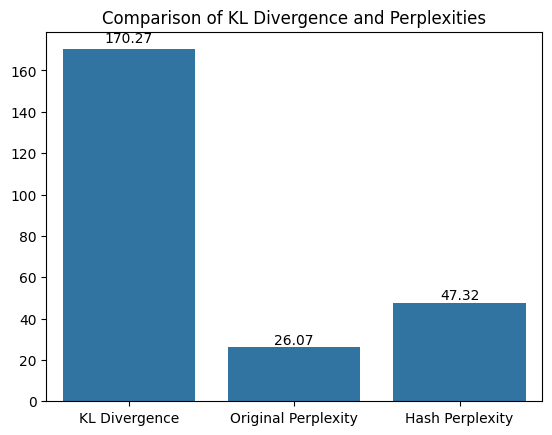

In [7]:
import datasets
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load a slice of the FineWeb dataset
fineweb_dataset = datasets.load_dataset("HuggingFaceFW/fineweb", "sample-10BT", split="train", streaming=True)
fineweb_sample = fineweb_dataset.take(1000) 
tokenizer.pad_token = tokenizer.eos_token

# Function to compute KL divergence between original and hash model
def compute_fineweb_metrics(original_model, hash_model, tokenizer, texts, max_length=512):
    import torch.nn.functional as F
    
    kl_divergences = []
    original_perplexities = []
    hash_perplexities = []
    
    for text in tqdm(texts):
        # Tokenize the text
        inputs = tokenizer(text, return_tensors="pt", max_length=max_length, truncation=True, padding=True)
        inputs = {k: v.to(original_model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            # Get logits from both models
            original_outputs = original_model(**inputs)
            hash_outputs = hash_model(**inputs)
            
            original_logits = original_outputs.logits
            hash_logits = hash_outputs.logits
            
            # Convert to probabilities
            original_probs = F.softmax(original_logits, dim=-1)
            hash_probs = F.softmax(hash_logits, dim=-1)
            
            # Compute KL divergence: KL(original || hash)
            kl_div = F.kl_div(hash_probs.log(), original_probs, reduction='batchmean')
            kl_divergences.append(kl_div.item())
            
            # Compute perplexities
            # Shift logits and labels for next token prediction
            shift_logits_original = original_logits[..., :-1, :].contiguous()
            shift_logits_hash = hash_logits[..., :-1, :].contiguous()
            shift_labels = inputs['input_ids'][..., 1:].contiguous()
            
            # Compute cross entropy loss
            original_loss = F.cross_entropy(shift_logits_original.view(-1, shift_logits_original.size(-1)), 
                                          shift_labels.view(-1), reduction='mean')
            hash_loss = F.cross_entropy(shift_logits_hash.view(-1, shift_logits_hash.size(-1)), 
                                      shift_labels.view(-1), reduction='mean')
            
            # Convert loss to perplexity
            original_perplexity = torch.exp(original_loss).item()
            hash_perplexity = torch.exp(hash_loss).item()
            
            original_perplexities.append(original_perplexity)
            hash_perplexities.append(hash_perplexity)
    
    return {
        'kl_divergences': kl_divergences,
        'original_perplexities': original_perplexities,
        'hash_perplexities': hash_perplexities
    }
# Extract texts from the dataset
texts = [sample['text'] for sample in fineweb_sample]

print("Computing KL divergences between flash and hash attention models...")
kl_divs = compute_fineweb_metrics(model, hash_model, tokenizer, texts)

# Create the bar plot
ax = sns.barplot(x=["KL Divergence", "Original Perplexity", "Hash Perplexity"], 
                 y=[np.mean(kl_divs['kl_divergences']), 
                    np.mean(kl_divs['original_perplexities']), 
                    np.mean(kl_divs['hash_perplexities'])])

# Add value labels on top of each bar
for i, v in enumerate([np.mean(kl_divs['kl_divergences']), 
                       np.mean(kl_divs['original_perplexities']), 
                       np.mean(kl_divs['hash_perplexities'])]):
    ax.text(i, v + v*0.01, f'{v:.2f}', ha='center', va='bottom')

plt.title('Comparison of KL Divergence and Perplexities')
plt.show()

### Downstream Metrics

To run the EleutherAI LM Evaluation Harness:
```
git clone --depth 1 https://github.com/EleutherAI/lm-evaluation-harness
cd lm-evaluation-harness
pip install -e .
pip install -e .[wandb]
```

You may also need to install a few dependencies:
```
pip install tiktoken wandb
```

In [ ]:
hash_model.save_pretrained("checkpoints/hash_model_default")
tokenizer.save_pretrained("checkpoints/hash_model_default")

In [23]:
!lm_eval --model hf \
    --model_args pretrained=meta-llama/Llama-3.2-1B-Instruct,dtype="bfloat16" \
    --tasks lambada_openai,hellaswag,piqa,boolq,winogrande,arc_easy,mmlu_abstract_algebra \
    --device cuda:1 \
    --batch_size auto:8 \
    --wandb_args project=lm-eval-harness-integration \
    --output_path eval_results \
    --log_samples

wandb: Currently logged in as: wz-ml (coactivelearning) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /home/will/important/Triton/SFCA/experiments/wandb/run-20250606_210620-obrmy6rd
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run resilient-terrain-10
wandb: ⭐️ View project at https://wandb.ai/coactivelearning/lm-eval-harness-integration
wandb: 🚀 View run at https://wandb.ai/coactivelearning/lm-eval-harness-integration/runs/obrmy6rd
2025-06-06:21:06:26 INFO     [__main__:440] Selected Tasks: ['arc_easy', 'boolq', 'hellaswag', 'lambada_openai', 'mmlu_abstract_algebra', 'piqa', 'winogrande']
2025-06-06:21:06:26 INFO     [evaluator:185] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-06-06:21:06:26 INFO     [evaluator:223] Initializing hf model, with arguments: {'pretrained': 'meta-l

In [32]:
ls

checkpoints/   lm-evaluation-harness/  table.html  wandb/
eval_results/  monkeypatching.ipynb    training/


In [40]:
!lm_eval --model hf \
    --model_args pretrained='training/checkpoints/[allparam_tune]hash_model_buckets_4_steps_1000.0_post_tune_steps_10000.0_maxlength_512,dtype=bfloat16,trust_remote_code=True' \
    --tasks lambada_openai,hellaswag,piqa,boolq,winogrande,arc_easy,mmlu_abstract_algebra \
    --device cuda:1 \
    --batch_size auto:8 \
    --wandb_args project=lm-eval-harness-integration \
    --output_path eval_results \
    --log_samples

wandb: Currently logged in as: wz-ml (coactivelearning) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.20.1
wandb: Run data is saved locally in /home/will/important/Triton/SFCA/experiments/wandb/run-20250606_212941-i63nx1vj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run misty-terrain-17
wandb: ⭐️ View project at https://wandb.ai/coactivelearning/lm-eval-harness-integration
wandb: 🚀 View run at https://wandb.ai/coactivelearning/lm-eval-harness-integration/runs/i63nx1vj
2025-06-06:21:29:46 INFO     [__main__:440] Selected Tasks: ['arc_easy', 'boolq', 'hellaswag', 'lambada_openai', 'mmlu_abstract_algebra', 'piqa', 'winogrande']
2025-06-06:21:29:46 INFO     [evaluator:185] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-06-06:21:29:46 INFO     [evaluator:223] Initializing hf model, with arguments: {'pretrained': 'training/c

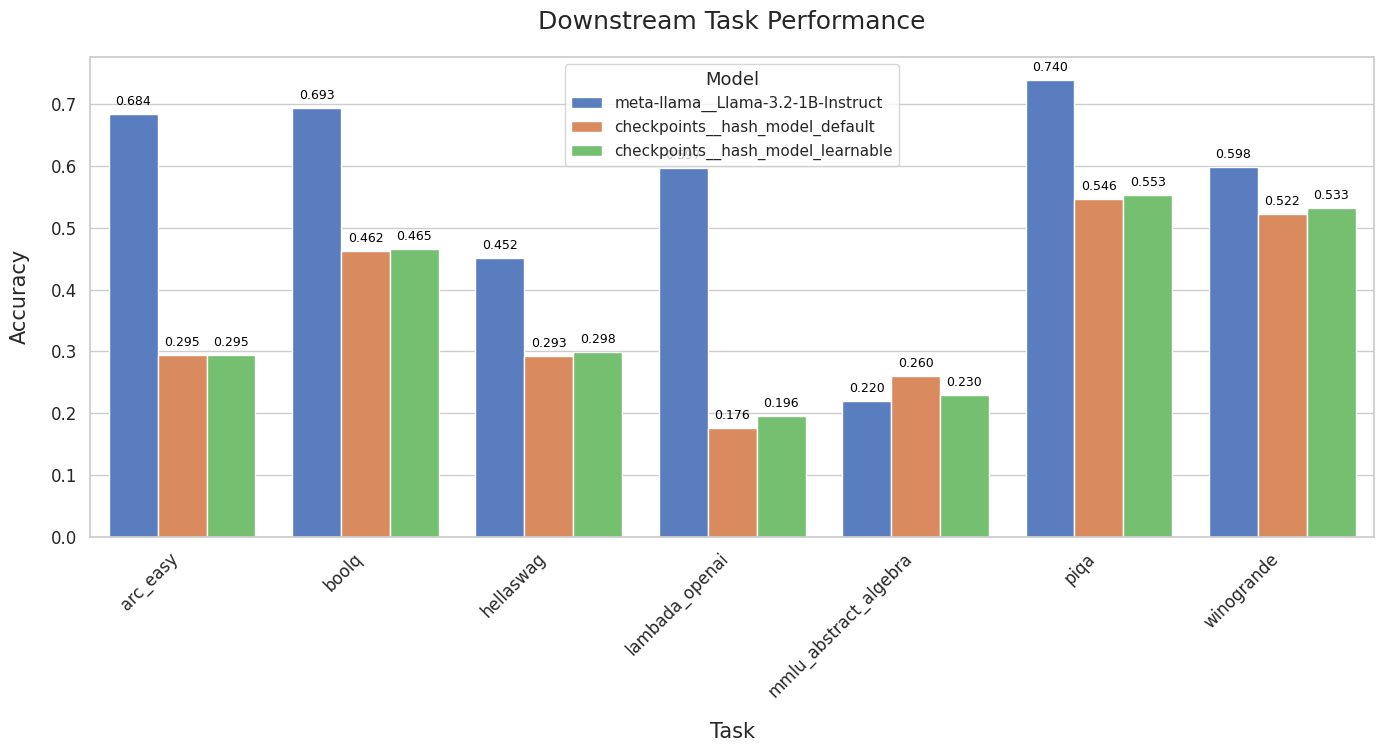

In [1]:
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List

def extract_results(model_dir, model_path):
    model_results_path = [f for f in os.listdir(os.path.join(model_dir, model_path)) if f.startswith("results")][0]
    full_path = os.path.join(model_dir, model_path, model_results_path)
    model_results = json.load(open(full_path))
    extracted_data = []
    for task_name, task_metrics in model_results["results"].items():
        accuracy = task_metrics.get("acc,none")
        if accuracy is not None:
            extracted_data.append({
                "Task": task_name,
                "Model": model_path,
                "Accuracy (acc,none)": float(accuracy) # Ensure accuracy is float
            })
        else:
            print(f"Warning: 'acc,none' not found for task '{task_name}' in model '{full_path}'.")
    return extracted_data

def plot_results(result_dir: str, result_paths: List[str]):
    all_data = []
    for path in result_paths:
        all_data.extend(extract_results(result_dir, path))
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(14, 8)) # Increased figure size for better label spacing
    sns.set_theme(style="whitegrid")

    ax = sns.barplot(x="Task", y="Accuracy (acc,none)", hue="Model", data=df, palette="muted")

    plt.title('Downstream Task Performance', fontsize=18, pad=20)
    plt.xlabel('Task', fontsize=15, labelpad=15)
    plt.ylabel('Accuracy', fontsize=15, labelpad=15)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)

    # Customize legend
    plt.legend(title='Model', fontsize=11, title_fontsize=13)

    # Add value labels on top of each bar
    for p in ax.patches:
        if p.get_height() > 0: # Only annotate bars with height > 0
            ax.annotate(format(p.get_height(), '.3f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 9), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for title

    # Display the plot
    plt.show()

plot_results(result_dir = "eval_results",
             result_paths = ["meta-llama__Llama-3.2-1B-Instruct",
                            "checkpoints__hash_model_default",
                            "checkpoints__hash_model_learnable"])

### Speed Metrics


Benchmarking sequence length: 256
Benchmarking original model forward pass...
Benchmarking original model backward pass...
Benchmarking hash model forward pass...
Benchmarking hash model backward pass...
Original model forward: 0.0147s ± 0.0004s
Original model backward: 0.0449s ± 0.0002s
Hash model forward: 0.0148s ± 0.0000s
Hash model backward: 0.0326s ± 0.0003s
Forward speedup: 0.99x
Backward speedup: 1.38x

Benchmarking sequence length: 512
Benchmarking original model forward pass...
Benchmarking original model backward pass...
Benchmarking hash model forward pass...
Benchmarking hash model backward pass...
Original model forward: 0.0264s ± 0.0001s
Original model backward: 0.0818s ± 0.0003s
Hash model forward: 0.0270s ± 0.0001s
Hash model backward: 0.0580s ± 0.0002s
Forward speedup: 0.98x
Backward speedup: 1.41x

Benchmarking sequence length: 1024
Benchmarking original model forward pass...
Benchmarking original model backward pass...
Benchmarking hash model forward pass...
Benchma

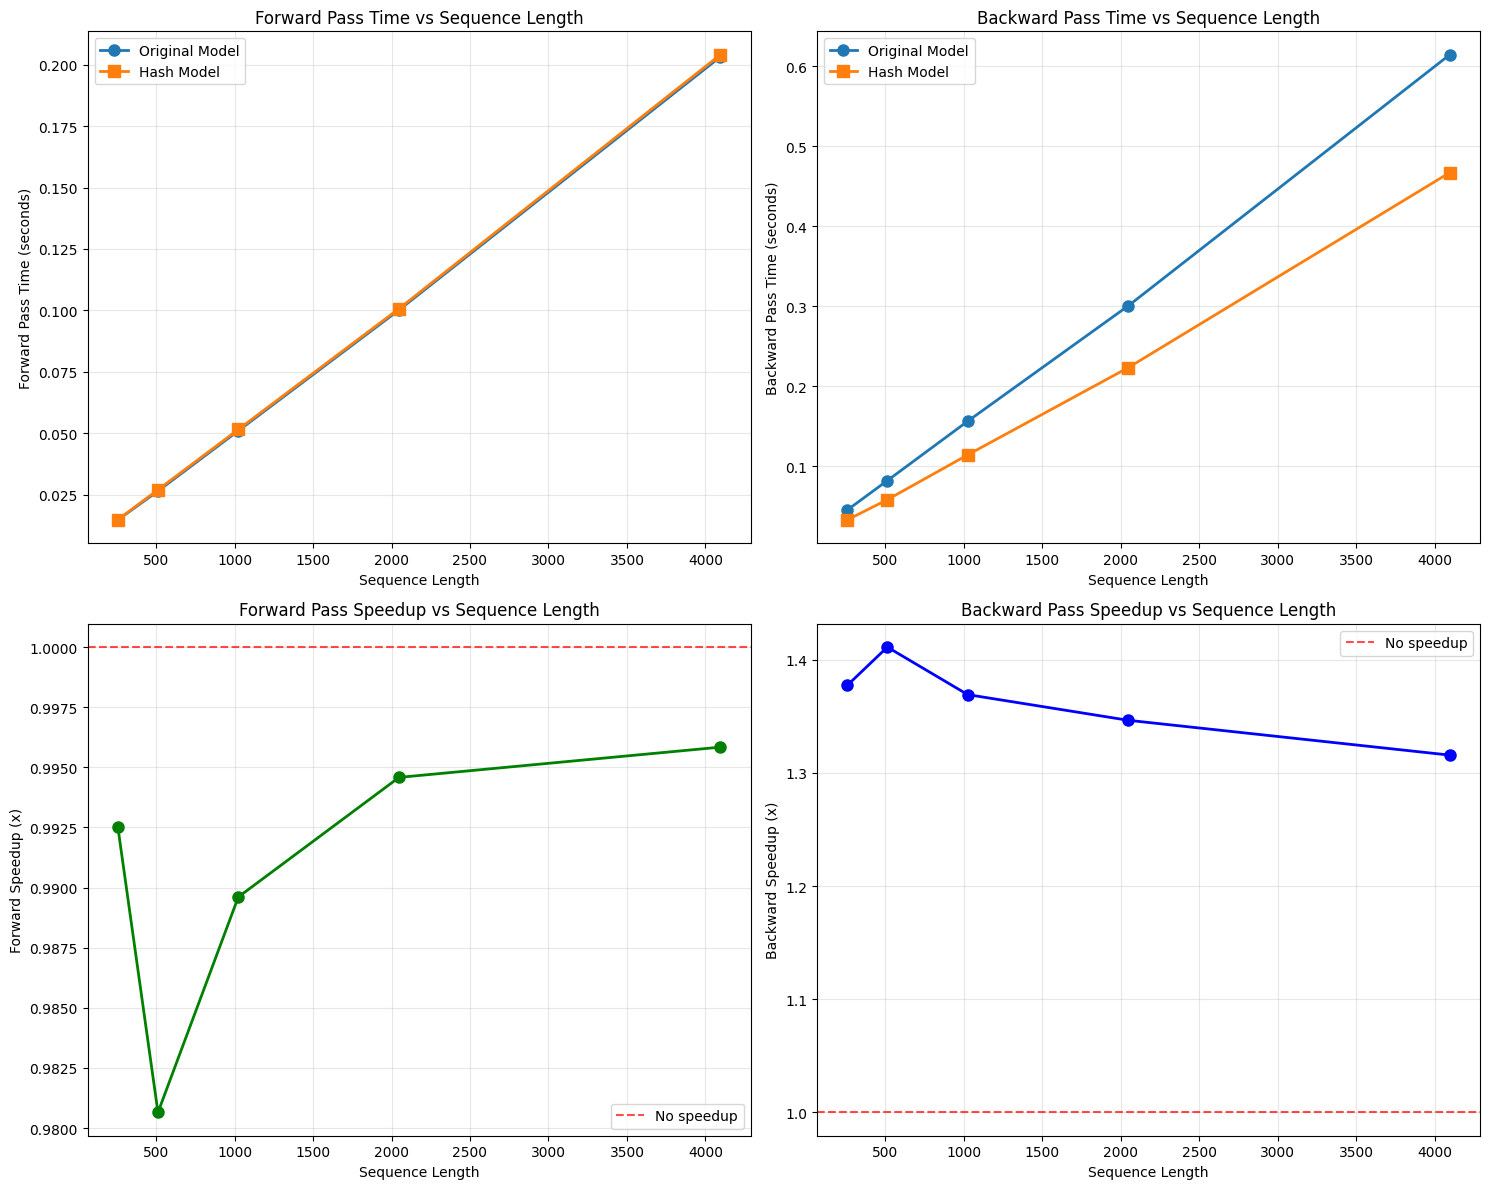

In [8]:
import time
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

device = model.device
torch.cuda.set_device(device)
def benchmark_models(original_model, hash_model, tokenizer, seq_lengths=[256, 512, 1024, 2048, 4096], num_warmup=3, num_runs=10):
    """Benchmark both models at different sequence lengths for forward and backward passes"""
    results = {}
    
    # Set models to train mode for backward pass benchmarking
    original_model.train()
    hash_model.train()
    
    for seq_len in seq_lengths:
        print(f"\nBenchmarking sequence length: {seq_len}")
        
        # Generate random sequences for this length
        random_sequences = []
        for _ in range(num_warmup + num_runs):
            # Generate random token IDs (avoiding special tokens)
            random_ids = [random.randint(1, tokenizer.vocab_size - 1000) for _ in range(seq_len)]
            random_sequences.append(random_ids)
        
        # Benchmark original model - Forward pass
        original_forward_times = []
        print("Benchmarking original model forward pass...")
        
        with torch.no_grad():
            # Warmup runs
            for i in range(num_warmup):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                _ = original_model(input_ids)
            
            # Actual benchmark runs
            for i in range(num_warmup, num_warmup + num_runs):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                
                torch.cuda.synchronize()
                start_time = time.time()
                _ = original_model(input_ids)
                torch.cuda.synchronize()
                end_time = time.time()
                
                original_forward_times.append(end_time - start_time)
        
        # Benchmark original model - Backward pass
        original_backward_times = []
        print("Benchmarking original model backward pass...")
        
        # Warmup runs
        for i in range(num_warmup):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            outputs = original_model(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            original_model.zero_grad()
        
        # Actual benchmark runs
        for i in range(num_warmup, num_warmup + num_runs):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            
            torch.cuda.synchronize()
            start_time = time.time()
            outputs = original_model(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            torch.cuda.synchronize()
            end_time = time.time()
            
            original_backward_times.append(end_time - start_time)
            original_model.zero_grad()
        
        # Benchmark hash model - Forward pass
        hash_forward_times = []
        print("Benchmarking hash model forward pass...")
        
        with torch.no_grad():
            # Warmup runs
            for i in range(num_warmup):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                _ = hash_model.forward(input_ids)
            
            # Actual benchmark runs
            for i in range(num_warmup, num_warmup + num_runs):
                input_ids = torch.tensor([random_sequences[i]], device=device)
                
                torch.cuda.synchronize()
                start_time = time.time()
                _ = hash_model.forward(input_ids)
                torch.cuda.synchronize()
                end_time = time.time()
                
                hash_forward_times.append(end_time - start_time)
        
        # Benchmark hash model - Backward pass
        hash_backward_times = []
        print("Benchmarking hash model backward pass...")
        
        # Warmup runs
        for i in range(num_warmup):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            outputs = hash_model.forward(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            hash_model.zero_grad()
        
        # Actual benchmark runs
        for i in range(num_warmup, num_warmup + num_runs):
            input_ids = torch.tensor([random_sequences[i]], device=device)
            
            torch.cuda.synchronize()
            start_time = time.time()
            outputs = hash_model.forward(input_ids)
            loss = outputs.logits.sum()
            loss.backward()
            torch.cuda.synchronize()
            end_time = time.time()
            
            hash_backward_times.append(end_time - start_time)
            hash_model.zero_grad()
        
        results[seq_len] = {
            'original_forward_times': original_forward_times,
            'original_backward_times': original_backward_times,
            'hash_forward_times': hash_forward_times,
            'hash_backward_times': hash_backward_times,
            'original_forward_mean': np.mean(original_forward_times),
            'original_backward_mean': np.mean(original_backward_times),
            'hash_forward_mean': np.mean(hash_forward_times),
            'hash_backward_mean': np.mean(hash_backward_times),
            'forward_speedup': np.mean(original_forward_times) / np.mean(hash_forward_times),
            'backward_speedup': np.mean(original_backward_times) / np.mean(hash_backward_times)
        }
        
        print(f"Original model forward: {np.mean(original_forward_times):.4f}s ± {np.std(original_forward_times):.4f}s")
        print(f"Original model backward: {np.mean(original_backward_times):.4f}s ± {np.std(original_backward_times):.4f}s")
        print(f"Hash model forward: {np.mean(hash_forward_times):.4f}s ± {np.std(hash_forward_times):.4f}s")
        print(f"Hash model backward: {np.mean(hash_backward_times):.4f}s ± {np.std(hash_backward_times):.4f}s")
        print(f"Forward speedup: {results[seq_len]['forward_speedup']:.2f}x")
        print(f"Backward speedup: {results[seq_len]['backward_speedup']:.2f}x")
    
    return results
# Run benchmarks
benchmark_results = benchmark_models(model, hash_model, tokenizer)

# Plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

seq_lengths = list(benchmark_results.keys())
original_forward_times = [benchmark_results[seq_len]['original_forward_mean'] for seq_len in seq_lengths]
original_backward_times = [benchmark_results[seq_len]['original_backward_mean'] for seq_len in seq_lengths]
hash_forward_times = [benchmark_results[seq_len]['hash_forward_mean'] for seq_len in seq_lengths]
hash_backward_times = [benchmark_results[seq_len]['hash_backward_mean'] for seq_len in seq_lengths]
forward_speedups = [benchmark_results[seq_len]['forward_speedup'] for seq_len in seq_lengths]
backward_speedups = [benchmark_results[seq_len]['backward_speedup'] for seq_len in seq_lengths]

# Plot forward pass times
ax1.plot(seq_lengths, original_forward_times, 'o-', label='Original Model', linewidth=2, markersize=8)
ax1.plot(seq_lengths, hash_forward_times, 's-', label='Hash Model', linewidth=2, markersize=8)
ax1.set_xlabel('Sequence Length')
ax1.set_ylabel('Forward Pass Time (seconds)')
ax1.set_title('Forward Pass Time vs Sequence Length')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot backward pass times
ax2.plot(seq_lengths, original_backward_times, 'o-', label='Original Model', linewidth=2, markersize=8)
ax2.plot(seq_lengths, hash_backward_times, 's-', label='Hash Model', linewidth=2, markersize=8)
ax2.set_xlabel('Sequence Length')
ax2.set_ylabel('Backward Pass Time (seconds)')
ax2.set_title('Backward Pass Time vs Sequence Length')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot forward speedup
ax3.plot(seq_lengths, forward_speedups, 'o-', color='green', linewidth=2, markersize=8)
ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
ax3.set_xlabel('Sequence Length')
ax3.set_ylabel('Forward Speedup (x)')
ax3.set_title('Forward Pass Speedup vs Sequence Length')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot backward speedup
ax4.plot(seq_lengths, backward_speedups, 'o-', color='blue', linewidth=2, markersize=8)
ax4.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='No speedup')
ax4.set_xlabel('Sequence Length')
ax4.set_ylabel('Backward Speedup (x)')
ax4.set_title('Backward Pass Speedup vs Sequence Length')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()